<a href="https://www.kaggle.com/code/ailafelixa/pharma-sales-analysis?scriptVersionId=116174698" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pharma-sales-data/salesdaily.csv
/kaggle/input/pharma-sales-data/salesweekly.csv
/kaggle/input/pharma-sales-data/salesmonthly.csv
/kaggle/input/pharma-sales-data/saleshourly.csv


### Descrição dos dados ###
[Descrição completa e fonte podem ser encontradas aqui](https://www.kaggle.com/datasets/milanzdravkovic/pharma-sales-data) 

The dataset is built from the initial dataset consisted of 600000 transactional data collected in 6 years (period 2014-2019), indicating date and time of sale, pharmaceutical drug brand name and sold quantity, exported from Point-of-Sale system in the individual pharmacy. Selected group of drugs from the dataset (57 drugs) is classified to the following Anatomical Therapeutic Chemical (ATC) Classification System categories:

M01AB - Anti-inflammatory and antirheumatic products, non-steroids, Acetic acid derivatives and related substances

M01AE - Anti-inflammatory and antirheumatic products, non-steroids, Propionic acid derivatives

N02BA - Other analgesics and antipyretics, Salicylic acid and derivatives

N02BE/B - Other analgesics and antipyretics, Pyrazolones and Anilides

N05B - Psycholeptics drugs, Anxiolytic drugs

N05C - Psycholeptics drugs, Hypnotics and sedatives drugs

R03 - Drugs for obstructive airway diseases

R06 - Antihistamines for systemic use

____________________________________________________

#### **Nosso objetivo é avaliar a venda de diferentes medicamentos, de modo a conseguir capturar alguns insigths importantes como:**
#### 
*1.Quais classes de medicamentos estão apresentando aumento ou diminuição de demanda ao longo dos anos?*

*2. Quais as classes de medicamentos mais e menos vendidos por mês?*

*3. Quais os meses com mais e menos vendas?*

## Importação e pré-processamento ##

In [2]:
#Primeiro, vamos importar e checar a estrutura dos dados
pharma_sales_data = pd.read_csv('/kaggle/input/pharma-sales-data/salesmonthly.csv')
pharma_sales_data.head()
#pharma_sales_data.tail()

#Podemos notar que os dados já estão ordenados pela data e que a coleta dos dados ocorre no último dia de cada mês.
#Vamos ver em qual formato os dados estão armazenados
pharma_sales_data.dtypes

#A coluna de data está com tipo 'object', mas para trabalharmos com as datas corretamente devemos converte-la para o tipo datetime64
pharma_sales_data['datum'] = pd.to_datetime(pharma_sales_data['datum'], format='%Y-%m-%d')
pharma_sales_data.dtypes

datum    datetime64[ns]
M01AB           float64
M01AE           float64
N02BA           float64
N02BE           float64
N05B            float64
N05C            float64
R03             float64
R06             float64
dtype: object

### 1. Quais classes de medicamentos apresentaram aumento ou diminuição de demanda ao longo dos anos? ##

In [3]:
#Primeiro vamos selecionar os dados referentes aos anos de 2014 (nosso start-point) e de 2019 (nosso end-point)
df_1 = pharma_sales_data.loc[(pharma_sales_data.datum.dt.year == 2014) | (pharma_sales_data.datum.dt.year == 2019)]
df_1.loc[:,'datum'] = df_1.datum.dt.year
df_1 = df_1.groupby('datum').sum() #Calculando a quantidade de vendas para cada classe de medicamento em cada ano
df_1.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
datum,,,,,,,,
2014,1510.77,1333.594,1683.279,10094.555,4355.0,303.0,1277.0,828.30
2019,1517.27,1117.221,879.800,8011.616,2405.6,196.0,2050.0,1073.57


In [4]:
#Vamos calcular o delta (diferença no número de unidades vendidas no ano de 2019 menos o número de unidades vendidas no ano de 2014)
delta = df_1.diff()
delta = delta.reset_index()
delta = delta.loc[delta.datum == 2019]
delta = delta.drop(columns='datum')
delta = round(delta)
delta_str = delta.applymap(str) #Gerando um dataframe de strings para auxiliar na legenda dos gráficos

In [5]:
#Vamos calcular também a proporção de crescimento ou decréscimo comparando 2019 com 2014
proporcao = df_1.iloc[1]/df_1.iloc[0]
proporcao = pd.DataFrame(proporcao)
proporcao = proporcao.rename(columns={0:'proporcao'})
proporcao = round(proporcao,2)

[Text(0.5, 0, 'Ano'), Text(0, 0.5, 'Quantidade de medicamentos vendidos')]

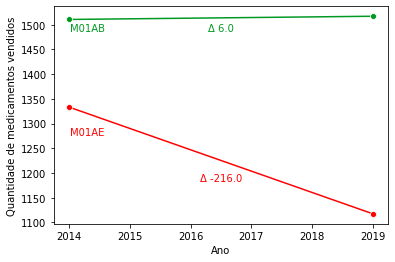

In [6]:
# Vamos comparar o desempenho de medicamentos com ATC similares, começando pelos anti-inflamatórios
ax = sns.lineplot(x=df_1.index, y=df_1.M01AB, ci = None, marker='o', color='#009923')
plt.text(0.1, 0.9, df_1.columns[0], horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes, color='#009923')
plt.text(0.5, 0.9, 'Δ '+delta_str.iloc[0,0], horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes, color='#009923')
bx = sns.lineplot(x=df_1.index, y=df_1.M01AE, ci = None, marker='o', color='red')
plt.text(0.1, 0.42, df_1.columns[1], horizontalalignment='center',
     verticalalignment='center', transform=bx.transAxes,color='red')
plt.text(0.5, 0.21, 'Δ '+delta_str.iloc[0,1], horizontalalignment='center',
     verticalalignment='center', transform=bx.transAxes,color='red')
ax.set(xlabel='Ano', ylabel='Quantidade de medicamentos vendidos')

[Text(0.5, 0, 'Ano'), Text(0, 0.5, 'Quantidade de medicamentos vendidos')]

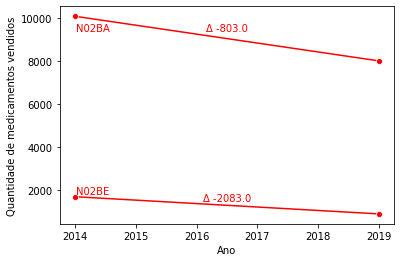

In [7]:
#Outros analgésicos e anti-piréticos
cx = sns.lineplot(x=df_1.index, y=df_1.N02BA, ci = None, marker='o', color='red')
plt.text(0.1, 0.90, df_1.columns[2], horizontalalignment='center',
     verticalalignment='center', transform=cx.transAxes, color='red')
plt.text(0.5, 0.9, 'Δ '+delta_str.iloc[0,2], horizontalalignment='center',
     verticalalignment='center', transform=cx.transAxes, color='red')
dx = sns.lineplot(x=df_1.index, y=df_1.N02BE, ci = None, marker='o', color='red')
plt.text(0.1, 0.15, df_1.columns[3], horizontalalignment='center',
     verticalalignment='center', transform=dx.transAxes, color='red')
plt.text(0.5, 0.12, 'Δ '+delta_str.iloc[0,3], horizontalalignment='center',
     verticalalignment='center', transform=dx.transAxes, color='red')
cx.set(xlabel='Ano', ylabel='Quantidade de medicamentos vendidos')

[Text(0.5, 0, 'Ano'), Text(0, 0.5, 'Quantidade de medicamentos vendidos')]

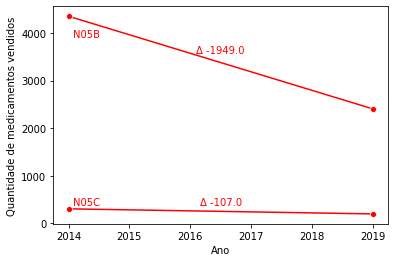

In [8]:
#Psicolépticos
ex=sns.lineplot(x=df_1.index, y=df_1.N05B, ci = None, marker='o', color='red')
plt.text(0.1, 0.87, df_1.columns[4], horizontalalignment='center',
     verticalalignment='center', transform=ex.transAxes, color='red')
plt.text(0.5, 0.80, 'Δ '+delta_str.iloc[0,4], horizontalalignment='center',
     verticalalignment='center', transform=ex.transAxes, color='red')
fx=sns.lineplot(x=df_1.index, y=df_1.N05C, ci = None, marker='o', color='red')
plt.text(0.1, 0.1, df_1.columns[5], horizontalalignment='center',
     verticalalignment='center', transform=fx.transAxes, color='red')
plt.text(0.5, 0.1, 'Δ '+delta_str.iloc[0,5], horizontalalignment='center',
     verticalalignment='center', transform=fx.transAxes, color='red')
ex.set(xlabel='Ano', ylabel='Quantidade de medicamentos vendidos')

[Text(0.5, 0, 'Ano'), Text(0, 0.5, 'Quantidade de medicamentos vendidos')]

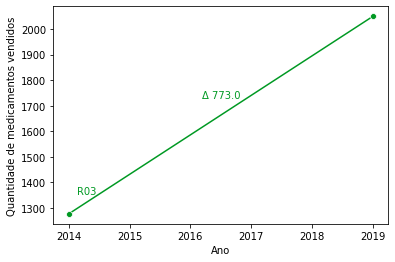

In [9]:
#Fármacos para o tratamento de doenças pulmonares obstrutivas
r1x = sns.lineplot(x=df_1.index, y=df_1.R03, ci = None, marker='o', color='#009923')
plt.text(0.1, 0.15, df_1.columns[6], horizontalalignment='center',
     verticalalignment='center', transform=r1x.transAxes, color='#009923')
plt.text(0.5, 0.59, 'Δ '+delta_str.iloc[0,6], horizontalalignment='center',
     verticalalignment='center', transform=r1x.transAxes, color='#009923')
r1x.set(xlabel='Ano', ylabel='Quantidade de medicamentos vendidos')

[Text(0.5, 0, 'Ano'), Text(0, 0.5, 'Quantidade de medicamentos vendidos')]

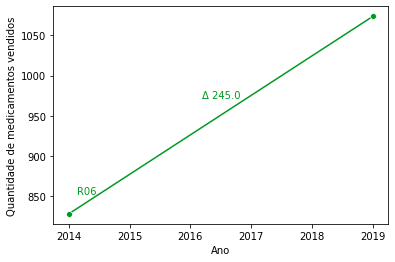

In [10]:
#Anti-histamínicos
r2x = sns.lineplot(x=df_1.index, y=df_1.R06, ci = None, marker='o', color='#009923')
plt.text(0.1, 0.15, df_1.columns[7], horizontalalignment='center',
     verticalalignment='center', transform=r2x.transAxes, color='#009923')
plt.text(0.5, 0.59, 'Δ '+delta_str.iloc[0,7], horizontalalignment='center',
     verticalalignment='center', transform=r2x.transAxes, color='#009923')
r2x.set(xlabel='Ano', ylabel='Quantidade de medicamentos vendidos')

<AxesSubplot:ylabel='proporcao'>

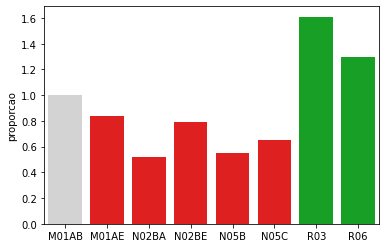

In [11]:
#Agora vamos visualizar os dados juntos para termos uma noção global do crescimento e decréscimo proporcional para cada medicamento
#Para não ter que definir manualmente todas as cores, vamos elaborar uma paleta de cores de forma condicional
cores_prop = ['red' if num < 1 else '#00B713' if num > 1 else '#D3D3D3' for num in proporcao.proporcao]
sns.barplot(x=proporcao.index, y=proporcao.proporcao, palette=cores_prop)